In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, GRU
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [2]:

key_id = 'PK04UHV69AF2QULV4REU'
secret_key = '7g1qUN7qjsfW3U6oSccYYtHyQdoewJ12ANDQmSKd'
endpoint = 'https://paper-api.alpaca.markets'

In [3]:
# connect to alpaca api
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime


stock_client = StockHistoricalDataClient(key_id, secret_key)

# get 1 years worth data on Nvidia by the day. Could also use TimeFrame.Minute for daily data
request_params = StockBarsRequest(symbol_or_symbols=['NVDA'],
                                  timeframe=TimeFrame.Day,
                                  start=datetime(2020, 1, 1),
                                  end=datetime(2022, 1, 1)
                                  )

bars = stock_client.get_stock_bars(request_params)

In [4]:
data=bars.df.reset_index()
data.head()

,symbol,timestamp,open,high,low,close,volume,trade_count,vwap
0,NVDA,2020-01-02 05:00:00+00:00,238.85,239.91,236.720,239.91,5941969.0,67912.0,238.723319
1,NVDA,2020-01-03 05:00:00+00:00,235.00,237.83,234.100,236.07,5145208.0,63605.0,236.384392
2,NVDA,2020-01-06 05:00:00+00:00,232.36,237.27,231.270,237.06,6572812.0,73912.0,235.468778
3,NVDA,2020-01-07 05:00:00+00:00,238.20,241.77,236.390,239.93,7980144.0,81624.0,239.855220
4,NVDA,2020-01-08 05:00:00+00:00,239.76,242.04,238.149,240.38,6931017.0,70240.0,240.313148


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, SimpleRNN
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
import math

In [6]:
traning_set=data.iloc[0:505-180,2:3].values
test_set=data.iloc[505-180:,2:3].values

sc=MinMaxScaler(feature_range=(0,1))
training_set_scaled=sc.fit_transform(traning_set)
test_set=sc.transform(test_set)


In [7]:
from gc import callbacks


x_train=[]
y_train=[]

x_test=[]
y_test=[]


for i in range(60, len(training_set_scaled)):
    x_train.append(training_set_scaled[i - 60:i, 0])
    y_train.append(training_set_scaled[i, 0])

np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)

x_train, y_train = np.array(x_train), np.array(y_train)


x_train = np.reshape(x_train, (x_train.shape[0], 60, 1))

for i in range(60, len(test_set)):
    x_test.append(test_set[i - 60:i, 0])
    y_test.append(test_set[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], 60, 1))

In [8]:
model = tf.keras.Sequential([
    GRU(80, return_sequences=True),
    Dropout(0.2),
    GRU(100),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mean_squared_error') 

checkpoint_save_path = "./checkpoint/stock1.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='val_loss')

history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), validation_freq=1,
                    callbacks=[cp_callback])

model.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

-------------load the model-----------------
Epoch 1/50


2022-10-02 16:31:25.909555: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-02 16:31:25.909832: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-10-02 16:31:26.003227: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-02 16:31:27.691548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-02 16:31:27.912183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-02 16:31:28.053282: I tensorflow/core/grappler/o

5/5 [==============================] - ETA: 0s - loss: 0.0119

2022-10-02 16:31:29.343774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-02 16:31:29.412773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-02 16:31:29.504502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 4s 320ms/step - loss: 0.0119 - val_loss: 0.0384
Epoch 2/50
5/5 [==============================] - 0s 43ms/step - loss: 0.0071 - val_loss: 0.0517
Epoch 3/50
5/5 [==============================] - 0s 42ms/step - loss: 0.0109 - val_loss: 0.0420
Epoch 4/50
5/5 [==============================] - 0s 56ms/step - loss: 0.0055 - val_loss: 0.0319
Epoch 5/50
5/5 [==============================] - 0s 54ms/step - loss: 0.0054 - val_loss: 0.0307
Epoch 6/50
5/5 [==============================] - 0s 44ms/step - loss: 0.0047 - val_loss: 0.0356
Epoch 7/50
5/5 [==============================] - 0s 44ms/step - loss: 0.0053 - val_loss: 0.0377
Epoch 8/50
5/5 [==============================] - 0s 43ms/step - loss: 0.0045 - val_loss: 0.0337
Epoch 9/50
5/5 [==============================] - 0s 42ms/step - loss: 0.0037 - val_loss: 0.0308
Epoch 10/50
5/5 [==============================] - 0s 42ms/step - loss: 0.0037 - val_loss: 0.0328
Epoch 11/50
5/5 [======================

In [9]:
from matplotlib.pyplot import hist


file=open('./weight.txt','w')
for v in model.trainable_variables:
    file.write(str(v.name)+'\n')
    file.write(str(v.shape)+'\n')
    file.write(str(v.numpy())+'\n')
file.close()

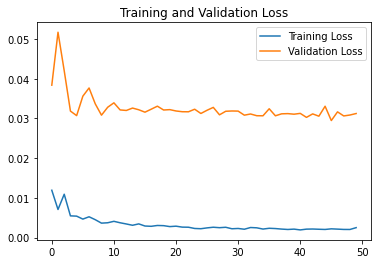

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

2022-10-02 16:31:46.196184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-02 16:31:46.261455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-02 16:31:46.353574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 62ms/step


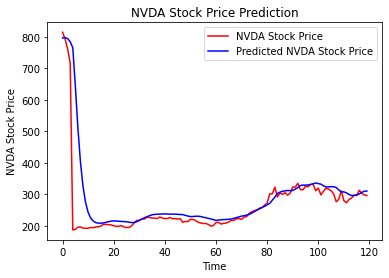

In [11]:
################## predict ######################

predicted_stock_price = model.predict(x_test)

predicted_stock_price = sc.inverse_transform(predicted_stock_price)

real_stock_price = sc.inverse_transform(test_set[60:])

plt.plot(real_stock_price, color='red', label='NVDA Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted NVDA Stock Price')
plt.title('NVDA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('NVDA Stock Price')
plt.legend()
plt.show()

In [12]:
##########evaluate##############
# calculate MSE 
mse = mean_squared_error(predicted_stock_price, real_stock_price)
# calculate RMSE 
rmse = math.sqrt(mean_squared_error(predicted_stock_price, real_stock_price))
# calculate MAE 
mae = mean_absolute_error(predicted_stock_price, real_stock_price)
print('mse: %.6f' % mse)
print('rmse: %.6f' % rmse)
print('mae: %.6f' % mae)

mse: 6159.506122
rmse: 78.482521
mae: 27.131185
